hid_orderings [1, 2, 2, 1, 2, 2, 1, 0, 1, 0, 2, 1, 2, 0, 0, 0] size 16
num hid layers: 1
expanded_input_ordering [0, 0, 0, 0, 0, 0, 0, 0, 1] size 9
expanded_output_ordering [2, 2] size 2
hid_orderings [1, 2, 1, 3, 2, 0, 0, 2, 0, 3, 0, 3, 0, 4, 2, 6, 1, 3, 5, 2, 2, 4, 6, 6, 2, 5, 4, 2, 1, 0, 6, 0] size 32
num hid layers: 1
expanded_input_ordering [0, 1, 1, 1, 1, 1, 1, 1, 1, 2] size 10
expanded_output_ordering [3, 3, 6, 6] size 4
hid_orderings [7, 8, 2, 9, 13, 11, 5, 1, 14, 7, 9, 12, 5, 0, 2, 10, 5, 13, 11, 14, 10, 4, 11, 0, 7, 13, 7, 2, 7, 8, 5, 13, 5, 4, 7, 3, 4, 5, 14, 1, 2, 2, 14, 13, 2, 8, 1, 4, 5, 8, 13, 12, 8, 11, 7, 10, 11, 3, 12, 8, 7, 5, 3, 7] size 64
num hid layers: 1
expanded_input_ordering [0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3] size 11
expanded_output_ordering [12, 12, 8, 8, 9, 9] size 6
hid_orderings [7, 39, 56, 49, 38, 31, 43, 7, 3, 54, 22, 42, 26, 22, 48, 21, 47, 51, 11, 61, 3, 26, 31, 52, 11, 35, 23, 58, 7, 16, 51, 20, 59, 3, 24, 6, 36, 60, 20, 40, 16, 27, 36, 15, 43, 31, 57,

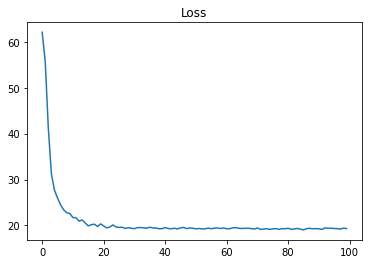

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE
from pyro.infer.autoguide import AutoDiagonalNormal, AutoNormal, AutoMultivariateNormal
from gmade import GMADE
random.seed(123)
torch.manual_seed(123)

# NN used for p(x | y)
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

class Experiment(nn.Module):
    def __init__(self):
        super().__init__()
        
        # guide 1
        self.hidden_size_1 = 8
        self.x1_net_1 = simpleNN()
        self.x2_net_1 = simpleNN()
        self.x3_net_1 = simpleNN()
        self.x4_net_1 = simpleNN()
        self.x5_net_1 = simpleNN()
        self.x6_net_1 = simpleNN()
        self.x7_net_1 = simpleNN()
        self.x8_net_1 = simpleNN()
        self.y1_net_1 = simpleNN()
        self.y2_net_1 = simpleNN()
        self.y3_net_1 = simpleNN()
        self.y4_net_1 = simpleNN()
        self.z1_net_1 = simpleNN(self.hidden_size_1 + 1)
        self.z2_net_1 = simpleNN(self.hidden_size_1 + 1)
        
        self.h0_1 = nn.Parameter(torch.zeros(self.hidden_size_1))
        self.hid_net_1 = simpleNN(self.hidden_size_1 + 8, out_size = self.hidden_size_1, t = "mlp")
        
        # guide 2
        self.hidden_size_2 = 8
        self.x1_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x2_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x3_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x4_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x5_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x6_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x7_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x8_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.y1_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.y2_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.y3_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.y4_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.z1_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.z2_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.h0_2 = nn.Parameter(torch.zeros(self.hidden_size_2))
        self.hid_net_2 = simpleNN(self.hidden_size_2 + 8, out_size = self.hidden_size_2, t = "mlp")
        
        # guide 3
        self.hidden_size_3 = 8
        self.x1_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.x2_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.x3_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.x4_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.x5_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.x6_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.x7_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.x8_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.y1_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.y2_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.y3_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.y4_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.z1_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.z2_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.h0_3 = nn.Parameter(torch.zeros(self.hidden_size_3))
        self.hid_net_3 = simpleNN(self.hidden_size_3 + 8, out_size = self.hidden_size_3, t = "mlp")

        # guide 4
        self.hidden_size_4 = 8
        self.x1_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.x2_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.x3_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.x4_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.x5_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.x6_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.x7_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.x8_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.y1_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.y2_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.y3_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.y4_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.z1_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.z2_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.h0_4 = nn.Parameter(torch.zeros(self.hidden_size_4))
        self.hid_net_4 = simpleNN(self.hidden_size_4 + 8 + 4 + 2, out_size = self.hidden_size_4, t = "mlp")
        
        # guide 5
        self.hidden_size_5 = 16
        self.x1_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.x2_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.x3_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.x4_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.x5_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.x6_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.x7_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.x8_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.y1_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.y2_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.y3_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.y4_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.z1_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.z2_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.h0_5 = nn.Parameter(torch.zeros(self.hidden_size_5))
        self.hid_net_5 = simpleNN(self.hidden_size_5 + 8 + 4 + 2, out_size = self.hidden_size_5, t = "mlp")
        
        # guide 6
        self.hidden_size_6 = 8
        self.x1_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.x2_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.x3_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.x4_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.x5_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.x6_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.x7_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.x8_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.y1_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.y2_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.y3_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.y4_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.z1_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.z2_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.h0_6 = nn.Parameter(torch.zeros(self.hidden_size_6))
        self.hid_net_6 = simpleNN(self.hidden_size_6 + 8 + 4 + 2 + 1, out_size = self.hidden_size_6, t = "mlp")
    
        # guide 7
        self.hidden_size_7 = 8
        self.x1_net_7 = simpleNN(self.hidden_size_7+ 2)
        self.x2_net_7 = simpleNN(self.hidden_size_7+ 1)
        self.x3_net_7 = simpleNN(self.hidden_size_7+ 2)
        self.x4_net_7 = simpleNN(self.hidden_size_7 + 1)
        self.x5_net_7 = simpleNN(self.hidden_size_7 + 2)
        self.x6_net_7 = simpleNN(self.hidden_size_7 + 1)
        self.x7_net_7 = simpleNN(self.hidden_size_7 + 2)
        self.x8_net_7 = simpleNN(self.hidden_size_7 + 1)
        self.y1_net_7 = simpleNN(self.hidden_size_7 + 2)
        self.y2_net_7= simpleNN(self.hidden_size_7 + 1)
        self.y3_net_7= simpleNN(self.hidden_size_7 + 2)
        self.y4_net_7= simpleNN(self.hidden_size_7 + 1)
        self.z1_net_7= simpleNN(self.hidden_size_7 + 2)
        self.z2_net_7= simpleNN(self.hidden_size_7 + 1)
        self.h0_7= nn.Parameter(torch.zeros(self.hidden_size_7))
        self.hid_net_7 = simpleNN(self.hidden_size_7 + 1, out_size = self.hidden_size_7, t = "mlp")
        
        # guide 7 made
        
        self.hidden_size_7_made = 6
        self.input_size = self.hidden_size_7_made + 1
        self.out_size = 14 * 2
        
                                
        # guide 8
        self.hidden_size_8 = 8
        self.x1_net_8 = simpleNN(self.hidden_size_8+ 2)
        self.x2_net_8 = simpleNN(self.hidden_size_8+ 1)
        self.x3_net_8 = simpleNN(self.hidden_size_8+ 2)
        self.x4_net_8 = simpleNN(self.hidden_size_8 + 1)
        self.x5_net_8 = simpleNN(self.hidden_size_8 + 2)
        self.x6_net_8 = simpleNN(self.hidden_size_8 + 1)
        self.x7_net_8 = simpleNN(self.hidden_size_8 + 2)
        self.x8_net_8 = simpleNN(self.hidden_size_8 + 1)
        self.y1_net_8 = simpleNN(self.hidden_size_8 + 2)
        self.y2_net_8 = simpleNN(self.hidden_size_8 + 1)
        self.y3_net_8 = simpleNN(self.hidden_size_8 + 2)
        self.y4_net_8 = simpleNN(self.hidden_size_8 + 1)
        self.z1_net_8 = simpleNN(self.hidden_size_8 + 2)
        self.z2_net_8 = simpleNN(self.hidden_size_8 + 1)
        self.h0_8= nn.Parameter(torch.zeros(self.hidden_size_8))
        self.hid_net_8 = simpleNN(self.hidden_size_8 + 2, out_size = self.hidden_size_8, t = "mlp")
                                
        # guide 9
        self.hidden_size_9 = 8
        self.x1_net_9 = simpleNN(self.hidden_size_9+ 2)
        self.x2_net_9 = simpleNN(self.hidden_size_9+ 1)
        self.x3_net_9 = simpleNN(self.hidden_size_9+ 2)
        self.x4_net_9 = simpleNN(self.hidden_size_9 + 1)
        self.x5_net_9 = simpleNN(self.hidden_size_9 + 2)
        self.x6_net_9 = simpleNN(self.hidden_size_9 + 1)
        self.x7_net_9 = simpleNN(self.hidden_size_9 + 2)
        self.x8_net_9 = simpleNN(self.hidden_size_9 + 1)
        self.y1_net_9 = simpleNN(self.hidden_size_9 + 2)
        self.y2_net_9 = simpleNN(self.hidden_size_9 + 1)
        self.y3_net_9 = simpleNN(self.hidden_size_9 + 2)
        self.y4_net_9 = simpleNN(self.hidden_size_9 + 1)
        self.z1_net_9 = simpleNN(self.hidden_size_9 + 2)
        self.z2_net_9 = simpleNN(self.hidden_size_9 + 1)
        self.h0_9 = nn.Parameter(torch.zeros(self.hidden_size_9))
        self.hid_net_9 = simpleNN(self.hidden_size_9 + 4, out_size = self.hidden_size_9, t = "mlp")
        
        # guide full_made
        self.hidden_size_full_made = 8
        input_dim_dict = {
            "h" : self.hidden_size_full_made,
            "r" : 1
        }
        var_dim_dict = {
            "x1" : 1,
            "x2" : 1,
            "x3" : 1,
            "x4" : 1,
            "x5" : 1,
            "x6" : 1,
            "x7" : 1,
            "x8" : 1,
            "y1" : 1,
            "y2" : 1,
            "y3" : 1,
            "y4" : 1,
            "z1" : 1,
            "z2" : 1
        }
        dependency_dict = {
            "z2" : ["h", "r"],
            "z1" : ["h", "r", "z2"],
            "y4" : ["h", "z2"],
            "y3" : ["h", "z2", "y4"],
            "y2" : ["h", "z1"],
            "y1" : ["h", "z1", "y2"],
            "x8" : ["h", "y4"],
            "x7" : ["h", "y4", "x8"],
            "x6" : ["h", "y3"],
            "x5" : ["h", "y3", "x6"],
            "x4" : ["h", "y2"],
            "x3" : ["h", "y2", "x4"],
            "x2" : ["h", "y1"],
            "x1" : ["h", "y1", "x2"]
        }
        self.full_made = GMADE(input_dim_dict, dependency_dict, var_dim_dict)
        self.h0_full_made = nn.Parameter(torch.zeros(self.hidden_size_full_made))
        self.hid_net_full_made = simpleNN(self.hidden_size_full_made + 1, out_size = self.hidden_size_full_made, t = "mlp")
        
    def model(self, n, obses):
        def tree_model(i, mu):
            x1 = pyro.sample(f"x1{i}", dist.Normal(mu, 1.0))
            x2 = pyro.sample(f"x2{i}", dist.Normal(mu, 1.0))
            x3 = pyro.sample(f"x3{i}", dist.Normal(mu, 1.0))
            x4 = pyro.sample(f"x4{i}", dist.Normal(mu, 1.0))
            x5 = pyro.sample(f"x5{i}", dist.Normal(mu, 1.0))
            x6 = pyro.sample(f"x6{i}", dist.Normal(mu, 1.0))
            x7 = pyro.sample(f"x7{i}", dist.Normal(mu, 1.0))
            x8 = pyro.sample(f"x8{i}", dist.Normal(mu, 1.0))
            y1 = pyro.sample(f"y1{i}", dist.Normal(x1+x2, 1.0))
            y2 = pyro.sample(f"y2{i}", dist.Normal(x3+x4, 1.0))
            y3 = pyro.sample(f"y3{i}", dist.Normal(x5+x6, 1.0))
            y4 = pyro.sample(f"y4{i}", dist.Normal(x7+x8, 1.0))
            z1 = pyro.sample(f"z1{i}", dist.Normal(y1+y2, 1.0))
            z2 = pyro.sample(f"z2{i}", dist.Normal(y3+y4, 1.0))
            return pyro.sample(f"obs{i}", dist.Normal(z1+z2, 1.0), obs=obses[i])
            
        pyro.module("model", self)
        mu = 0
        for i in range(n):
            mu = tree_model(i, mu)
    
    # guide 1 basically inverse the arrows in the model, add hidden states that z2 depends on
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # sample from i = 0, 1, ..., n-2, n-1
    def guide_1(self, n, obses):
        
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_1([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_1([obses[i], hid])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_1([z2])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_1([z2])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_1([z1])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_1([z1])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_1([y4])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_1([y4])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_1([y3])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_1([y3])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_1([y2])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_1([y2])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_1([y1])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_1([y1])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_1([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_1
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide_1_1 basically inverse the arrows in the model, add hidden states that z2 depends on
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # different from guide_1 by sample from i = n-1, n-2, ..., 0
    def guide_1_1(self, n, obses):
        
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_1([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_1([obses[i], hid])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_1([z2])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_1([z2])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_1([z1])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_1([z1])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_1([y4])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_1([y4])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_1([y3])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_1([y3])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_1([y2])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_1([y2])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_1([y1])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_1([y1])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_1([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_1
        for i in range(n-1, -1, -1):
            hid = tree_guide(i, hid)
    
    # guide 2 basically inverse the arrows in the model, add hidden states that each RV
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # sample from i = 0, 1, ..., n-2, n-1
    def guide_2(self, n, obses):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_2([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_2([obses[i], hid])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_2([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_2([z2, hid])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_2([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_2([z1, hid])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_2([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_2([y4, hid])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_2([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_2([y3, hid])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_2([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_2([y2, hid])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_2([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_2([y1, hid])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_2([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_2
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 3 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # sample from i = 0, 1, ..., n-2, n-1
    
    def guide_3(self, n, obses):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_3([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_3([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_3([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_3([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_3([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_3([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_3([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_3([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_3([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_3([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_3([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_3([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_3([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_3([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_3([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_3
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 3_1 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # sample from i = n-1, n-2, ..., 1, 0
    
    def guide_3_1(self, n, obses):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_3([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_3([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_3([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_3([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_3([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_3([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_3([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_3([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_3([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_3([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_3([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_3([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_3([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_3([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_3([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_3
        for i in range(n-1, -1, -1):
            hid = tree_guide(i, hid)
    
    # guide 4 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled RVs in current iteration (x1,x2...x8, y1,...y4, z1,z2)
    # sample from i = 0, 1, ..., n-2, n-1
    
    def guide_4(self, n, obses):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_4([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_4([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_4([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_4([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_4([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_4([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_4([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_4([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_4([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_4([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_4([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_4([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_4([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_4([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_4([hid, x1, x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_4
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 5 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled RVs in current iteration (x1,x2...x8, y1,...y4, z1,z2)
    # sample from i = 0, 1, ..., n-2, n-1
    # increases hidden state dim from 8 to 16
    def guide_5(self, n, obses):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_5([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_5([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_5([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_5([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_5([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_5([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_5([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_5([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_5([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_5([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_5([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_5([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_5([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_5([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_5([hid, x1, x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_5
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 6 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled RVs in current iteration (x1,x2...x8, y1,...y4, z1,z2, obs)
    # sample from i = 0, 1, ..., n-2, n-1
    # different from guide_4 by adding obses[i] as an extra dependecy when updating hid

    def guide_6(self, n, obses):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_6([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_6([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_6([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_6([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_6([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_6([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_6([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_6([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_6([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_6([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_6([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_6([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_6([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_6([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_6([hid, x1, x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2, obses[i]])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_6
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 7 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and obs
    # sample from i = 0, 1, ..., n-2, n-1
    # different from guide_4 by adding obses[i] as an extra dependecy when updating hid

    def guide_7(self, n, obses):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_7([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_7([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_7([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_7([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_7([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_7([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_7([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_7([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_7([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_7([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_7([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_7([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_7([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_7([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_7([hid, obses[i]])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_7
        for i in range(n):
            hid = tree_guide(i, hid)
                                 
    # guide 8 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and z1, z2
    # sample from i = 0, 1, ..., n-2, n-1
    # different from guide_4 by adding obses[i] as an extra dependecy when updating hid

    def guide_8(self, n, obses):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_8([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_8([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_8([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_8([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_8([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_8([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_8([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_8([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_8([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_8([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_8([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_8([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_8([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_8([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_8([hid, z1, z2])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_8
        for i in range(n):
            hid = tree_guide(i, hid)
                                 
    
    # guide 9 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and y1, y2, y3. y4
    # sample from i = 0, 1, ..., n-2, n-1
    # different from guide_4 by adding obses[i] as an extra dependecy when updating hid
    
    def guide_9(self, n, obses):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_9([obses[i], hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_9([obses[i], hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_9([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_9([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_9([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_9([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_9([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_9([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_9([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_9([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_9([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_9([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_9([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_9([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_9([hid, y1, y2, y3, y4])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_9
        for i in range(n):
            hid = tree_guide(i, hid)
    
    def guide_full_made(self, n, obses):
        def tree_guide(i, hid):
            input_made = {
                "h" : hid,
                "r" : torch.unsqueeze(obses[i], dim=0)
            }
            
            output_dict = self.full_made(input_made, suffix=str(i))
            
            hid = self.hid_net_full_made([hid, obses[i]])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_full_made
        for i in range(n):
            hid = tree_guide(i, hid)

def generate_data():
    
    n_min = 2
    n_max = 4
    n = random.randint(n_min, n_max)
    obses = []
    mu = 0
    x_len = 8
    for i in range(n):
        x_noise = torch.randn(x_len) / 4
        x_mean = torch.zeros(x_len) + mu
        xs = torch.normal(x_mean, 1) + x_noise
        ys = []
        j = 0
        while j < len(xs):
            y = dist.Normal(xs[j] + xs[j+1], 2).sample()
            ys.append(y)
            j +=2
        
        zs = []
        j = 0
        while j < len(ys):
            z = dist.Normal(ys[j] + ys[j+1], 1.5).sample()
            zs.append(z)
            j +=2
        
        
        obs = dist.Normal(zs[0] + zs[1], 1).sample() / 5
        obses.append(obs)
        mu = obs
        
    return n, obses
    
data = []
num_data = 100
for _ in range(num_data):
    data.append(generate_data())

#print(data)
experiment = Experiment()
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
guide = experiment.guide_full_made # guide_1

#guide = AutoNormal(experiment.model)
#guide = AutoMultivariateNormal(experiment.model)
#guide = AutoDiagonalNormal(experiment.model)

svi = SVI(experiment.model, guide, optimizer, loss=Trace_ELBO())


n_steps = 100
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    
    for n, obses in data:
        imme_loss += svi.step(n, obses) / num_data
        
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {} Accumlated Loss: {}".format(step, n_steps, imme_loss, loss))
        loss = 0
    
plt.plot(loss_track)
plt.title("Loss")
plt.show()
    

In [2]:
# guide 1
[Step 10/100] Immediate Loss: 32.056255335211766 Accumlated Loss: 39.810146228253835
[Step 20/100] Immediate Loss: 30.77456396490336 Accumlated Loss: 30.907070715844633
[Step 30/100] Immediate Loss: 30.832169231176383 Accumlated Loss: 30.868072110861544
[Step 40/100] Immediate Loss: 30.20635374277832 Accumlated Loss: 30.786874743551017
[Step 50/100] Immediate Loss: 31.064358202517017 Accumlated Loss: 30.73660790809988
[Step 60/100] Immediate Loss: 30.461085685789595 Accumlated Loss: 30.735810206323862
[Step 70/100] Immediate Loss: 30.69941374212503 Accumlated Loss: 30.568582807511092
[Step 80/100] Immediate Loss: 31.283807360827932 Accumlated Loss: 30.603012248307465
[Step 90/100] Immediate Loss: 30.556891204416758 Accumlated Loss: 30.497190983921286
[Step 100/100] Immediate Loss: 30.619736705124378 Accumlated Loss: 30.699366100519896

SyntaxError: invalid syntax (<ipython-input-2-ca9d77f22370>, line 2)

In [ ]:
# guide_1_1
[Step 10/100] Immediate Loss: 33.08285777300596 Accumlated Loss: 42.140617132395505
[Step 20/100] Immediate Loss: 30.552316099703305 Accumlated Loss: 31.146604584604507
[Step 30/100] Immediate Loss: 30.533921941220754 Accumlated Loss: 30.85680748859048
[Step 40/100] Immediate Loss: 30.76778864353895 Accumlated Loss: 30.536550723701716
[Step 50/100] Immediate Loss: 30.1870471033454 Accumlated Loss: 30.73809576103092
[Step 60/100] Immediate Loss: 31.023994455933572 Accumlated Loss: 30.653320709526536
[Step 70/100] Immediate Loss: 31.379466826319703 Accumlated Loss: 30.791925778031345
[Step 80/100] Immediate Loss: 31.064741338491448 Accumlated Loss: 30.297557548731568
[Step 90/100] Immediate Loss: 30.665508285760872 Accumlated Loss: 30.577219336509703
[Step 100/100] Immediate Loss: 30.387796130776415 Accumlated Loss: 30.447961003541952

In [ ]:
# guide 2
[Step 10/100] Immediate Loss: 31.160341137945643 Accumlated Loss: 40.11236542010307
[Step 20/100] Immediate Loss: 29.47647261351348 Accumlated Loss: 29.61162685546279
[Step 30/100] Immediate Loss: 29.94969665110111 Accumlated Loss: 29.67519397190213
[Step 40/100] Immediate Loss: 29.2828398269415 Accumlated Loss: 29.308840560138226
[Step 50/100] Immediate Loss: 29.36908874571323 Accumlated Loss: 29.168527402102946
[Step 60/100] Immediate Loss: 29.091700927019115 Accumlated Loss: 28.999451614946132
[Step 70/100] Immediate Loss: 29.1920207542181 Accumlated Loss: 28.950033961921935
[Step 80/100] Immediate Loss: 30.127138351202017 Accumlated Loss: 28.875505193889143
[Step 90/100] Immediate Loss: 28.85039758533239 Accumlated Loss: 28.882422005444763
[Step 100/100] Immediate Loss: 28.979458193778992 Accumlated Loss: 28.880654528141022

In [ ]:
# guide 3
[Step 10/100] Immediate Loss: 26.031784344017506 Accumlated Loss: 36.08618940055371
[Step 20/100] Immediate Loss: 23.71810558915138 Accumlated Loss: 24.834602235227827
[Step 30/100] Immediate Loss: 24.366164560318005 Accumlated Loss: 24.285493285149336
[Step 40/100] Immediate Loss: 23.4816444569826 Accumlated Loss: 23.823054573804136
[Step 50/100] Immediate Loss: 23.566059122681615 Accumlated Loss: 24.03096249982715
[Step 60/100] Immediate Loss: 24.22875029921531 Accumlated Loss: 23.79123932659626
[Step 70/100] Immediate Loss: 24.362703014910227 Accumlated Loss: 23.839444131016734
[Step 80/100] Immediate Loss: 24.524240311384194 Accumlated Loss: 23.454850003451114
[Step 90/100] Immediate Loss: 23.35828918129206 Accumlated Loss: 23.429724233001476
[Step 100/100] Immediate Loss: 23.05758892029523 Accumlated Loss: 23.247113545954228

In [ ]:
# guide 3_1
[Step 10/100] Immediate Loss: 29.64976183772088 Accumlated Loss: 38.22538236251472
[Step 20/100] Immediate Loss: 25.34471814244986 Accumlated Loss: 26.440933385401955
[Step 30/100] Immediate Loss: 25.35544960319997 Accumlated Loss: 25.267824931949374
[Step 40/100] Immediate Loss: 24.37403639018536 Accumlated Loss: 24.840208679139614
[Step 50/100] Immediate Loss: 24.247421675920478 Accumlated Loss: 24.383337319314474
[Step 60/100] Immediate Loss: 25.045929816961284 Accumlated Loss: 24.55331683513522
[Step 70/100] Immediate Loss: 24.163105537891386 Accumlated Loss: 24.277232891410588
[Step 80/100] Immediate Loss: 23.972828967869276 Accumlated Loss: 24.21140722477435
[Step 90/100] Immediate Loss: 24.01401171565055 Accumlated Loss: 24.00979202204943
[Step 100/100] Immediate Loss: 24.33066892236472 Accumlated Loss: 24.13794069096446

In [ ]:
# guide 4
[Step 10/100] Immediate Loss: 24.68699115812778 Accumlated Loss: 37.01468467932939
[Step 20/100] Immediate Loss: 21.6624699795246 Accumlated Loss: 22.73940928918123
[Step 30/100] Immediate Loss: 21.166393940448767 Accumlated Loss: 21.316948004901416
[Step 40/100] Immediate Loss: 21.36728857249021 Accumlated Loss: 21.098873917281626
[Step 50/100] Immediate Loss: 20.981309909522533 Accumlated Loss: 20.997873998492956
[Step 60/100] Immediate Loss: 21.08762986898422 Accumlated Loss: 20.824197031199933
[Step 70/100] Immediate Loss: 20.935759621858594 Accumlated Loss: 20.822197566896673
[Step 80/100] Immediate Loss: 20.30705537825823 Accumlated Loss: 20.72653667473793
[Step 90/100] Immediate Loss: 20.73721558332443 Accumlated Loss: 20.64209464859963
[Step 100/100] Immediate Loss: 20.87153839617968 Accumlated Loss: 20.65713318750262

In [ ]:
# guide 5
[Step 10/100] Immediate Loss: 23.1993371462822 Accumlated Loss: 33.514440439701076
[Step 20/100] Immediate Loss: 21.155377793312088 Accumlated Loss: 21.891660819441086
[Step 30/100] Immediate Loss: 21.215811479985703 Accumlated Loss: 21.078007463216775
[Step 40/100] Immediate Loss: 21.20999110490082 Accumlated Loss: 21.014692111611367
[Step 50/100] Immediate Loss: 20.966142849922193 Accumlated Loss: 20.979130407631395
[Step 60/100] Immediate Loss: 20.94501889407635 Accumlated Loss: 20.84996331000328
[Step 70/100] Immediate Loss: 21.04487294763326 Accumlated Loss: 20.896094068676238
[Step 80/100] Immediate Loss: 20.460133520364757 Accumlated Loss: 20.75659060847759
[Step 90/100] Immediate Loss: 20.84229312330485 Accumlated Loss: 20.710244399458173
[Step 100/100] Immediate Loss: 20.769813348650935 Accumlated Loss: 20.68340155428648

In [ ]:
# guide 6
[Step 10/100] Immediate Loss: 20.42654618114233 Accumlated Loss: 28.889365255206823
[Step 20/100] Immediate Loss: 19.857153085172172 Accumlated Loss: 19.937184128135442
[Step 30/100] Immediate Loss: 19.520539140999315 Accumlated Loss: 19.629199158638713
[Step 40/100] Immediate Loss: 19.165769968926895 Accumlated Loss: 19.488673482775685
[Step 50/100] Immediate Loss: 19.41767822444439 Accumlated Loss: 19.426740706920622
[Step 60/100] Immediate Loss: 19.431891245543948 Accumlated Loss: 19.40624176305532
[Step 70/100] Immediate Loss: 19.494637635350234 Accumlated Loss: 19.350892909973858
[Step 80/100] Immediate Loss: 19.229742932021615 Accumlated Loss: 19.365910012155773
[Step 90/100] Immediate Loss: 19.331023247241966 Accumlated Loss: 19.303414241611957
[Step 100/100] Immediate Loss: 19.552925373315805 Accumlated Loss: 19.321839558482168

In [ ]:
### guide 7 ### best
[Step 10/100] Immediate Loss: 20.2772622281313 Accumlated Loss: 28.76096033588051
[Step 20/100] Immediate Loss: 19.679782972037792 Accumlated Loss: 19.731237277120353
[Step 30/100] Immediate Loss: 19.403315845429905 Accumlated Loss: 19.522962967753415
[Step 40/100] Immediate Loss: 19.093879950344558 Accumlated Loss: 19.36297418275476
[Step 50/100] Immediate Loss: 19.2976006630063 Accumlated Loss: 19.353287386298177
[Step 60/100] Immediate Loss: 19.316642963588237 Accumlated Loss: 19.31276805520058
[Step 70/100] Immediate Loss: 19.310542556643476 Accumlated Loss: 19.264885908722878
[Step 80/100] Immediate Loss: 19.276807580590248 Accumlated Loss: 19.28338193294406
[Step 90/100] Immediate Loss: 19.19589645862579 Accumlated Loss: 19.198544875502588
[Step 100/100] Immediate Loss: 19.4472383236885 Accumlated Loss: 19.247250556439162

In [ ]:
### gmade ###
[Step 10/100] Immediate Loss: 22.680389780998233 Accumlated Loss: 35.19650405162573
[Step 20/100] Immediate Loss: 20.381133034527302 Accumlated Loss: 21.011727388679983
[Step 30/100] Immediate Loss: 19.57214338630438 Accumlated Loss: 19.62186603462696
[Step 40/100] Immediate Loss: 19.315119618177416 Accumlated Loss: 19.436573924750093
[Step 50/100] Immediate Loss: 19.29497722923756 Accumlated Loss: 19.36097045993805
[Step 60/100] Immediate Loss: 19.204773218631747 Accumlated Loss: 19.309482787221672
[Step 70/100] Immediate Loss: 19.29591664344073 Accumlated Loss: 19.284042857289315
[Step 80/100] Immediate Loss: 19.228719753324977 Accumlated Loss: 19.211760253548626
[Step 90/100] Immediate Loss: 19.120977384448054 Accumlated Loss: 19.248472143501047
[Step 100/100] Immediate Loss: 19.145323577821248 Accumlated Loss: 19.25928099399805

In [ ]:
# guide 8
[Step 10/100] Immediate Loss: 22.467771414220337 Accumlated Loss: 34.07140950384736
[Step 20/100] Immediate Loss: 21.763280723392967 Accumlated Loss: 21.793595794767143
[Step 30/100] Immediate Loss: 21.077882419526578 Accumlated Loss: 21.09933529755473
[Step 40/100] Immediate Loss: 20.581267143785947 Accumlated Loss: 20.841164585858582
[Step 50/100] Immediate Loss: 21.248149825930597 Accumlated Loss: 20.92562254476547
[Step 60/100] Immediate Loss: 20.944569247066973 Accumlated Loss: 20.890202902674677
[Step 70/100] Immediate Loss: 20.514412646591662 Accumlated Loss: 20.68528026425838
[Step 80/100] Immediate Loss: 20.368839347958563 Accumlated Loss: 20.65337956503033
[Step 90/100] Immediate Loss: 20.631799390316022 Accumlated Loss: 20.61819331428409
[Step 100/100] Immediate Loss: 20.91762545168399 Accumlated Loss: 20.63467643406987

In [ ]:
# guide 9
[Step 10/100] Immediate Loss: 24.727704225182535 Accumlated Loss: 35.97320130950212
[Step 20/100] Immediate Loss: 23.37845941632986 Accumlated Loss: 23.7587587428689
[Step 30/100] Immediate Loss: 22.28792653501035 Accumlated Loss: 22.80557987380028
[Step 40/100] Immediate Loss: 21.437094094157214 Accumlated Loss: 22.30265956261754
[Step 50/100] Immediate Loss: 22.73526936858893 Accumlated Loss: 22.48900521808863
[Step 60/100] Immediate Loss: 23.203256192803387 Accumlated Loss: 22.573640926212075
[Step 70/100] Immediate Loss: 21.949498886764047 Accumlated Loss: 22.333624592006206
[Step 80/100] Immediate Loss: 21.99221489280463 Accumlated Loss: 22.276512214809657
[Step 90/100] Immediate Loss: 22.006299128532408 Accumlated Loss: 22.028557543367143
[Step 100/100] Immediate Loss: 22.434146136939518 Accumlated Loss: 22.160525921404357

In [ ]:
# AutoNormal
[Step 10/100] Immediate Loss: 1233.5509329861402 Accumlated Loss: 1227.3371018108132
[Step 20/100] Immediate Loss: 1223.710170497894 Accumlated Loss: 1198.8953249975439
[Step 30/100] Immediate Loss: 1214.6601654508706 Accumlated Loss: 1199.9680957393944
[Step 40/100] Immediate Loss: 1164.4792316886785 Accumlated Loss: 1196.4807624239027
[Step 50/100] Immediate Loss: 1185.8603583538534 Accumlated Loss: 1201.2587032988667
[Step 60/100] Immediate Loss: 1168.790014993846 Accumlated Loss: 1197.5709460456371
[Step 70/100] Immediate Loss: 1175.152639506459 Accumlated Loss: 1194.480629557699
[Step 80/100] Immediate Loss: 1200.5110745263096 Accumlated Loss: 1204.2938371902703
[Step 90/100] Immediate Loss: 1210.800975180566 Accumlated Loss: 1195.3925600020586
[Step 100/100] Immediate Loss: 1179.5571283224222 Accumlated Loss: 1201.02371161443

In [ ]:
# AutoMultivariateNormal
[Step 10/100] Immediate Loss: 1235.3812578570842 Accumlated Loss: 1236.1352865802646
[Step 20/100] Immediate Loss: 1210.2978770101067 Accumlated Loss: 1216.1027867695093
[Step 30/100] Immediate Loss: 1229.688204897046 Accumlated Loss: 1205.0053660194872
[Step 40/100] Immediate Loss: 1200.555576323867 Accumlated Loss: 1192.0478162692784
[Step 50/100] Immediate Loss: 1191.1188332122565 Accumlated Loss: 1196.5321274908779
[Step 60/100] Immediate Loss: 1191.3697812026737 Accumlated Loss: 1206.1590484446883
[Step 70/100] Immediate Loss: 1189.0993092578653 Accumlated Loss: 1185.5664499574898
[Step 80/100] Immediate Loss: 1184.2317881757021 Accumlated Loss: 1193.5602444505096
[Step 90/100] Immediate Loss: 1213.3458593541382 Accumlated Loss: 1189.3086517564059
[Step 100/100] Immediate Loss: 1194.0520617479087 Accumlated Loss: 1196.8081811218856

In [ ]:
# AutoDiagonalNormal
[Step 10/100] Immediate Loss: 1235.8018628519776 Accumlated Loss: 1236.249700816393
[Step 20/100] Immediate Loss: 1212.7352848732473 Accumlated Loss: 1217.2863890322446
[Step 30/100] Immediate Loss: 1233.1168017601972 Accumlated Loss: 1208.195502301395
[Step 40/100] Immediate Loss: 1205.5053979098793 Accumlated Loss: 1196.19749720788
[Step 50/100] Immediate Loss: 1196.6777249866725 Accumlated Loss: 1201.5737289296987
[Step 60/100] Immediate Loss: 1195.7460924953223 Accumlated Loss: 1211.1477473101022
[Step 70/100] Immediate Loss: 1194.371914086938 Accumlated Loss: 1191.4428508981468
[Step 80/100] Immediate Loss: 1189.6923706567293 Accumlated Loss: 1199.3408790806534
[Step 90/100] Immediate Loss: 1220.8790620434281 Accumlated Loss: 1195.186482142985
[Step 100/100] Immediate Loss: 1201.1263765621195 Accumlated Loss: 1203.2602218962313